<a href="https://colab.research.google.com/github/VirtueZhao/Dive_into_Deep_Learning/blob/main/7_4_Networks_with_Parallel_Concatenations_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import d2l
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
class Inception(nn.Module):
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)

    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)

    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))

    return torch.cat((p1,p2,p3,p4), dim=1)

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
          nn.ReLU(),
          nn.Conv2d(64, 192, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
b3 = nn.Sequential(
      Inception(192, 64, (96, 128), (16,32), 32),
      Inception(256, 128, (128, 192), (32, 96), 64),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [8]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [9]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
  print(layer)
  print()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

Sequential(
  (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

Sequential(
  (0): Inception(
    (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
    (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (p4_2): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Inception(
    (p1_1): C

In [13]:
X = torch.rand(size=(1, 1, 96, 96))
print(X.shape)
for layer in net:
  for sub_layer in layer:
    print(sub_layer)
    X = sub_layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
  print()

torch.Size([1, 1, 96, 96])
Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
Sequential output shape:	 torch.Size([1, 64, 48, 48])
ReLU()
Sequential output shape:	 torch.Size([1, 64, 48, 48])
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential output shape:	 torch.Size([1, 64, 24, 24])

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
Sequential output shape:	 torch.Size([1, 64, 24, 24])
ReLU()
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Sequential output shape:	 torch.Size([1, 192, 24, 24])
ReLU()
Sequential output shape:	 torch.Size([1, 192, 24, 24])
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential output shape:	 torch.Size([1, 192, 12, 12])

Inception(
  (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
  (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stri

TypeError: ignored

loss 0.257, train acc 0.902, test acc 0.880
1103.7 examples/sec on cuda:0


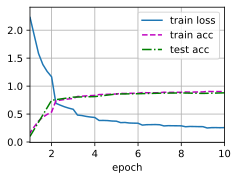

In [14]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())